In [1]:
import io
import tarfile
from pathlib import Path

import numpy as np

from ugradiolab import Record
from ugradiolab.analysis import Spectrum

DATA_SRC = 'labs/02/data/lab2_cold_cal.tar.gz'  # directory of .npz or .tar.gz archive


def _resolve_source(source):
    src = Path(source).expanduser()
    if src.exists():
        return src

    cwd = Path.cwd().resolve()
    for base in (cwd, *cwd.parents):
        candidate = (base / source).resolve()
        if candidate.exists():
            return candidate

    raise FileNotFoundError(
        f'Could not find {source!r}. cwd={cwd}. '
        'Tried cwd and all parent directories.'
    )


def _prefix_from_name(name):
    return Path(name).name.rsplit('_', 3)[0]


def _parse_dbm(prefix, stem):
    if not prefix.startswith(stem):
        return None
    try:
        return int(prefix.replace(stem, ''))
    except ValueError:
        return None


def load_dataset(source):
    src = _resolve_source(source)
    data = {}

    if src.is_dir():
        for f in sorted(src.glob('*.npz')):
            data[_prefix_from_name(f.name)] = Record.load(f)
    elif src.is_file() and src.suffixes[-2:] == ['.tar', '.gz']:
        # Iterate sequentially — gzip streams don't support backward seeks,
        # so getmembers() + random extractfile() can silently produce empty reads.
        with tarfile.open(src, 'r:gz') as tar:
            for m in tar:
                if not (m.isfile() and m.name.endswith('.npz')):
                    continue
                f = tar.extractfile(m)
                if f is None:
                    continue
                data[_prefix_from_name(m.name)] = Record.load(io.BytesIO(f.read()))
    else:
        raise FileNotFoundError(
            f'Expected a directory of .npz files or a .tar.gz archive, got: {src}'
        )

    if not data:
        raise RuntimeError(f'No .npz files found in: {src}')

    return data, src


data, resolved_src = load_dataset(DATA_SRC)

tone_dbm = sorted(
    d for d in (_parse_dbm(prefix, 'COLD-TONE-') for prefix in data) if d is not None
)
base_dbm = sorted(
    d for d in (_parse_dbm(prefix, 'COLD-BASE-') for prefix in data) if d is not None
)
paired_dbm = sorted(set(tone_dbm).intersection(base_dbm))

if not paired_dbm:
    raise RuntimeError('No paired COLD-TONE-<dBm> and COLD-BASE-<dBm> captures found.')

print(f'Loaded {len(data)} files from {resolved_src}')
print(f'Paired dBm levels: {paired_dbm}')
for key in sorted(data):
    rec = data[key]
    print(f'  {key:20s} ({"cal" if rec.uses_synth else "obs"})')

/home/ikaros/projects/ay-121/.venv/lib/python3.12/site-packages/rtlsdr/__init__.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Loaded 14 files from /home/ikaros/projects/ay-121/labs/02/data/lab2_cold_cal.tar.gz
Paired dBm levels: [-50, -46, -42, -38, -34, -30]
  COLD-BASE--30        (obs)
  COLD-BASE--34        (obs)
  COLD-BASE--38        (obs)
  COLD-BASE--42        (obs)
  COLD-BASE--46        (obs)
  COLD-BASE--50        (obs)
  COLD-BASE-POST       (obs)
  COLD-BASE-PRE        (obs)
  COLD-TONE--30        (cal)
  COLD-TONE--34        (cal)
  COLD-TONE--38        (cal)
  COLD-TONE--42        (cal)
  COLD-TONE--46        (cal)
  COLD-TONE--50        (cal)


In [25]:
data['COLD-TONE--42'].siggen_rf_on

True

In [2]:
import pandas as pd

rows = []
for prefix, rec in data.items():
    spec = Spectrum.from_record(rec)
    rows.append({
        'prefix': prefix,
        'type': 'cal' if rec.uses_synth else 'obs',
        'spec': spec,
        'unix_time': rec.unix_time,
        'siggen_freq': rec.siggen_freq if rec.uses_synth else np.nan,
        'siggen_amp': rec.siggen_amp if rec.uses_synth else np.nan,
        'siggen_rf_on': rec.siggen_rf_on if rec.uses_synth else False,
    })

if not rows:
    raise RuntimeError('No captures loaded; check DATA_SRC and load_dataset().')

df = pd.DataFrame(rows).sort_values('unix_time').reset_index(drop=True)
df

,prefix,type,spec,unix_time,siggen_freq,siggen_amp,siggen_rf_on
0,COLD-BASE-PRE,obs,"Spectrum(record=Record(data=array([[ 6. +3.j, ...",1.771289e+09,NaN,NaN,False
1,COLD-TONE--50,cal,"Spectrum(record=Record(data=array([[-5. -4.j, ...",1.771289e+09,1.421206e+09,-50.0,True
2,COLD-BASE--50,obs,"Spectrum(record=Record(data=array([[ -6. +3.j,...",1.771289e+09,NaN,NaN,False
3,COLD-TONE--46,cal,"Spectrum(record=Record(data=array([[ -7. -5.j,...",1.771289e+09,1.421206e+09,-46.0,True
4,COLD-BASE--46,obs,"Spectrum(record=Record(data=array([[ 12. +2.j,...",1.771289e+09,NaN,NaN,False
5,COLD-TONE--42,cal,"Spectrum(record=Record(data=array([[ 5. +0.j,...",1.771289e+09,1.421206e+09,-42.0,True
6,COLD-BASE--42,obs,"Spectrum(record=Record(data=array([[ 1. +1.j,...",1.771289e+09,NaN,NaN,False
7,COLD-TONE--38,cal,"Spectrum(record=Record(data=array([[ 6. -3.j,...",1.771289e+09,1.421206e+09,-38.0,True
8,COLD-BASE--38,obs,"Spectrum(record=Record(data=array([[ 3. +4.j, ...",1.771289e+09,NaN,NaN,False
9,COLD-TONE--34,cal,"Spectrum(record=Record(data=array([[ -5. -8.j,...",1.771289e+09,1.421206e+09,-34.0,True


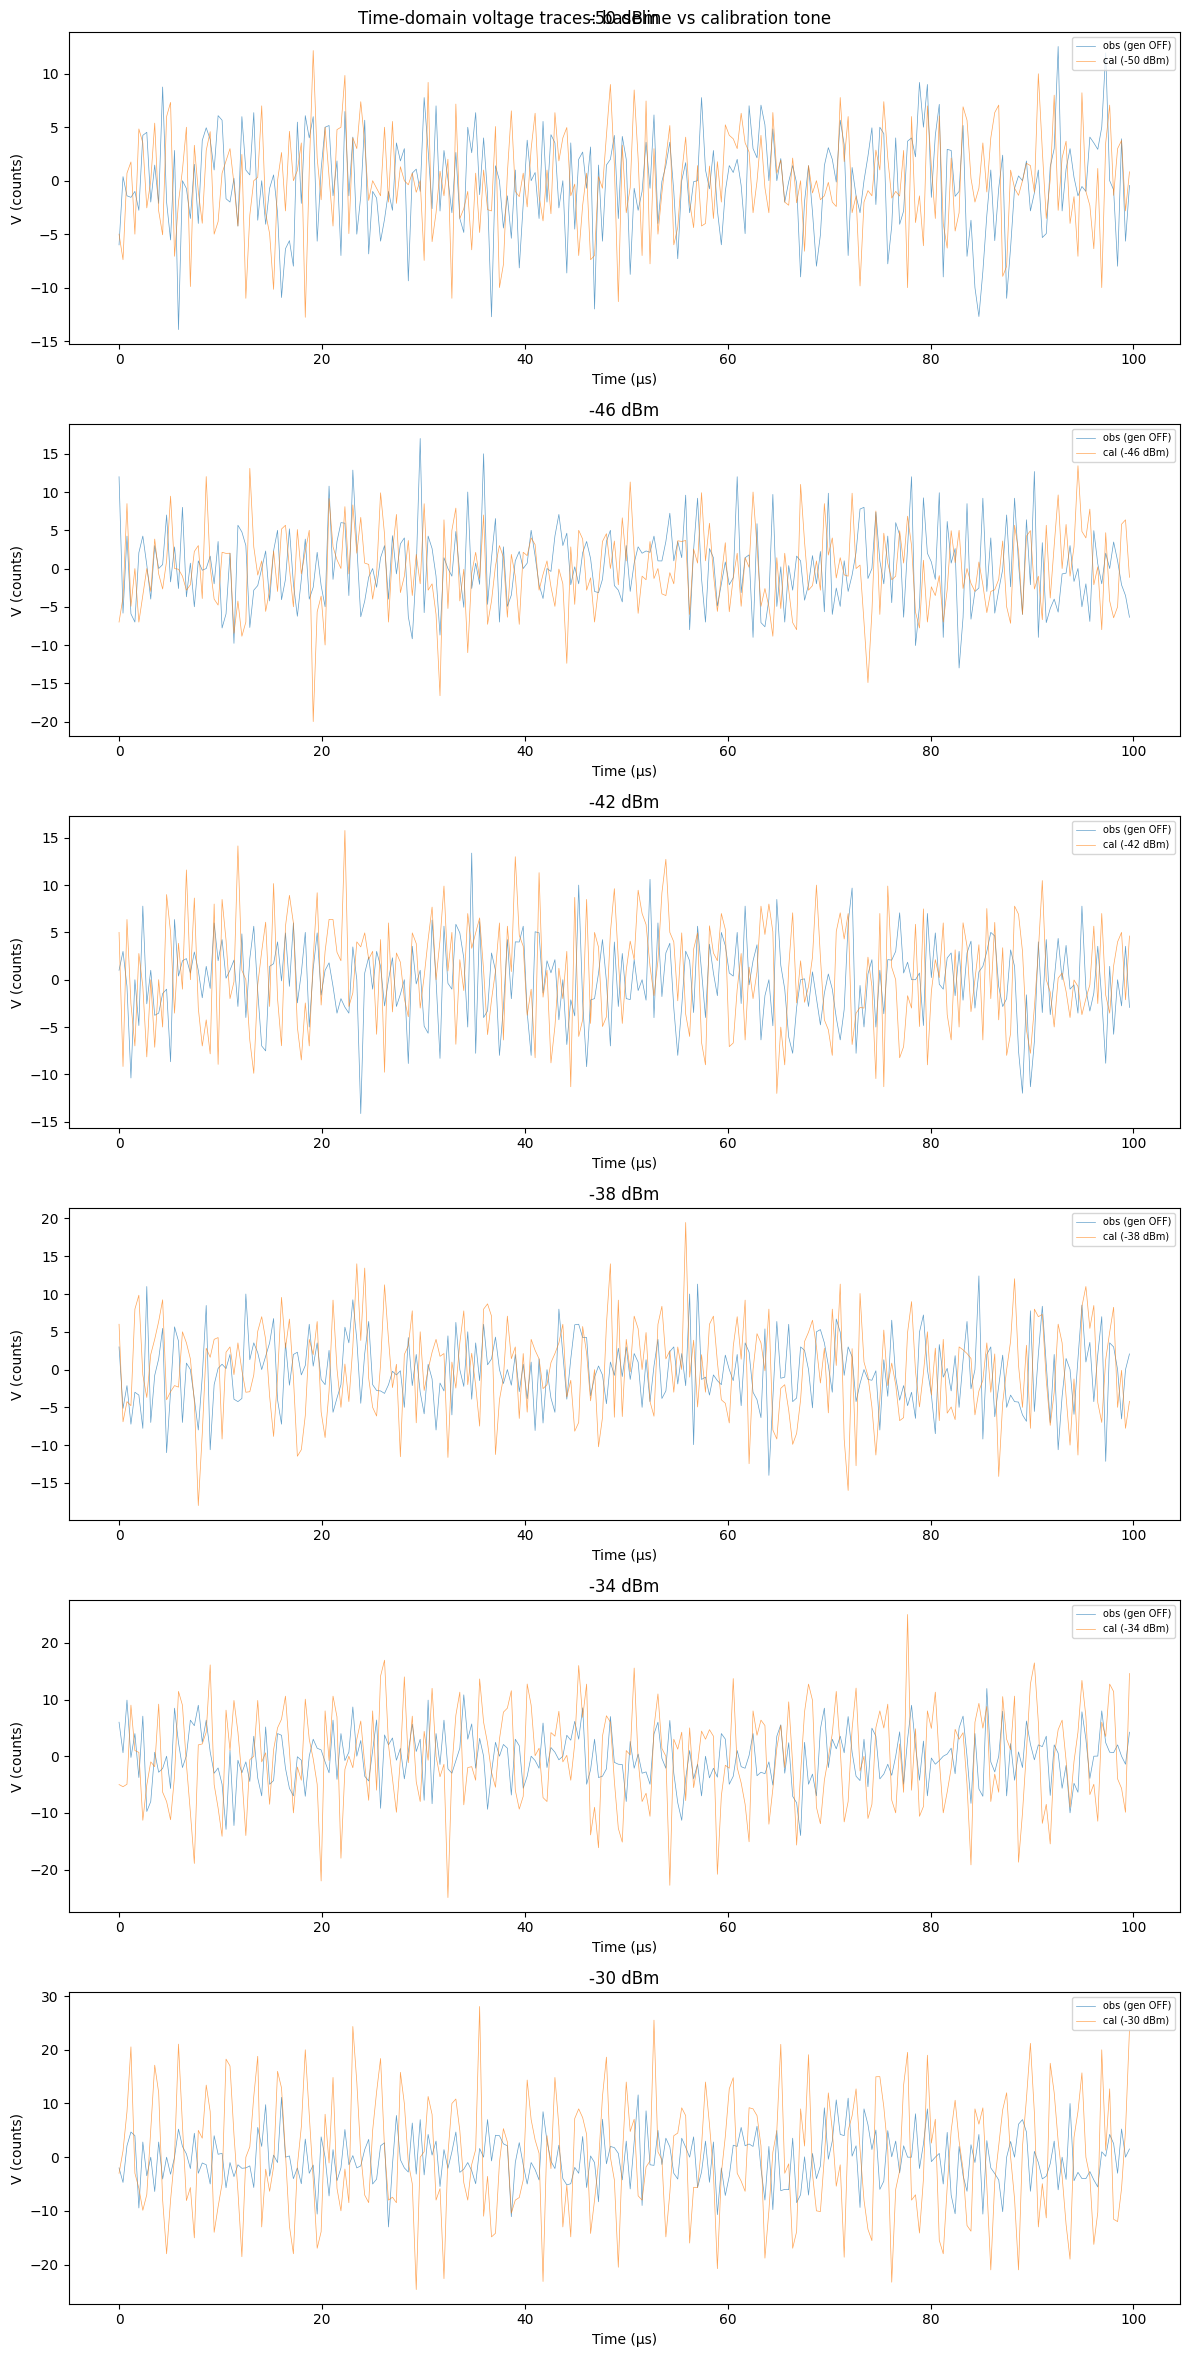

In [3]:
import matplotlib.pyplot as plt

nshow = 256  # samples to plot (first block only)

spec0     = df['spec'].iloc[0]
sample_rate = spec0.record.sample_rate
center_freq = spec0.record.center_freq
t_us = np.arange(nshow) / sample_rate * 1e6

fig, axes = plt.subplots(len(paired_dbm), 1, figsize=(12, 4 * len(paired_dbm)))
axes = np.atleast_1d(axes)

for i, dbm in enumerate(paired_dbm):
    ax = axes[i]
    cal_iq = df.loc[df['prefix'] == f'COLD-TONE-{dbm}', 'spec'].values[0].record.data
    obs_iq = df.loc[df['prefix'] == f'COLD-BASE-{dbm}', 'spec'].values[0].record.data

    t_s = np.arange(nshow) / sample_rate
    carrier_cos = np.cos(2 * np.pi * center_freq * t_s)
    carrier_sin = np.sin(2 * np.pi * center_freq * t_s)

    cal_rf = cal_iq[0, :nshow].real * carrier_cos - cal_iq[0, :nshow].imag * carrier_sin
    obs_rf = obs_iq[0, :nshow].real * carrier_cos - obs_iq[0, :nshow].imag * carrier_sin

    ax.plot(t_us, obs_rf, alpha=0.7, lw=0.5, label='obs (gen OFF)')
    ax.plot(t_us, cal_rf, alpha=0.7, lw=0.5, label=f'cal ({dbm} dBm)')
    ax.set_ylabel('V (counts)')
    ax.set_xlabel('Time (μs)')
    ax.set_title(f'{dbm} dBm')
    ax.legend(loc='upper right', fontsize=7)

fig.suptitle('Time-domain voltage traces: baseline vs calibration tone')
plt.tight_layout()
plt.show()

In [4]:
# Spectra are computed in Spectrum.from_record() during DataFrame construction.
spec0 = df['spec'].iloc[0]
print(f'Computed power spectra for {len(df)} captures')
print(f'Frequency range: {spec0.freqs_mhz[0]:.3f} – {spec0.freqs_mhz[-1]:.3f} MHz')
print(f'Frequency bins:  {len(spec0.freqs_mhz)}')

Computed power spectra for 14 captures
Frequency range: 1418.720 – 1421.279 MHz
Frequency bins:  2048


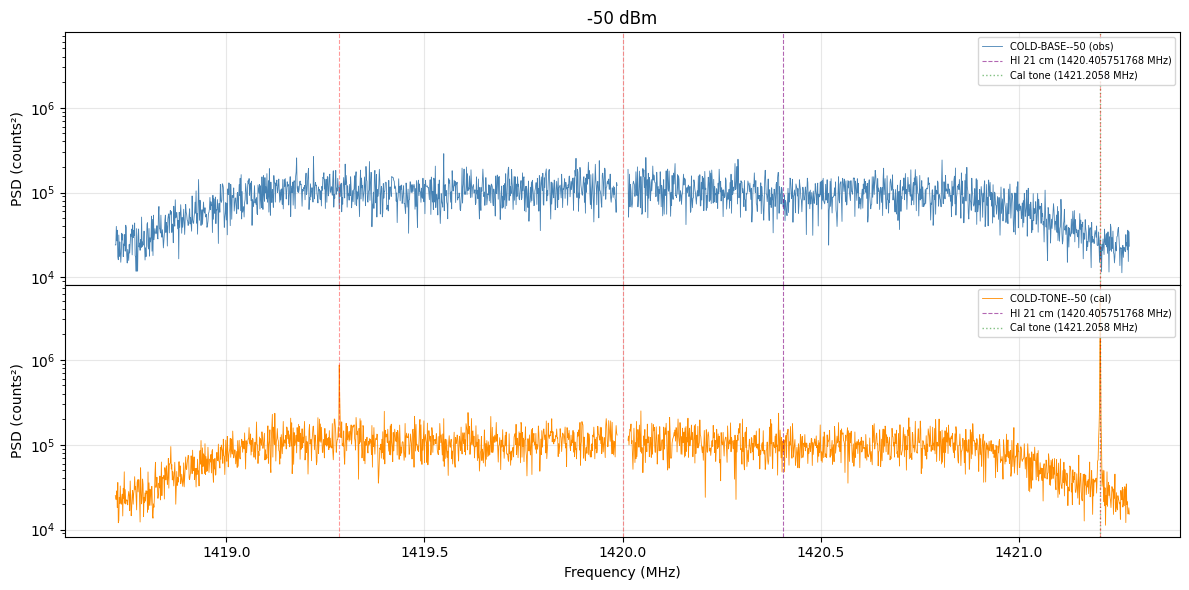

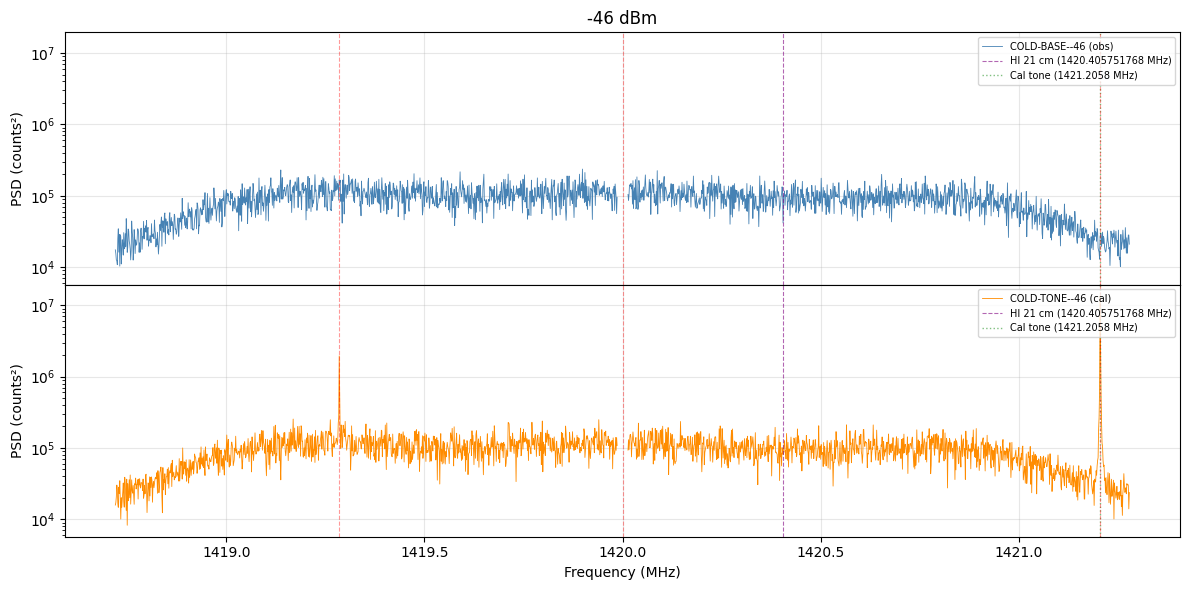

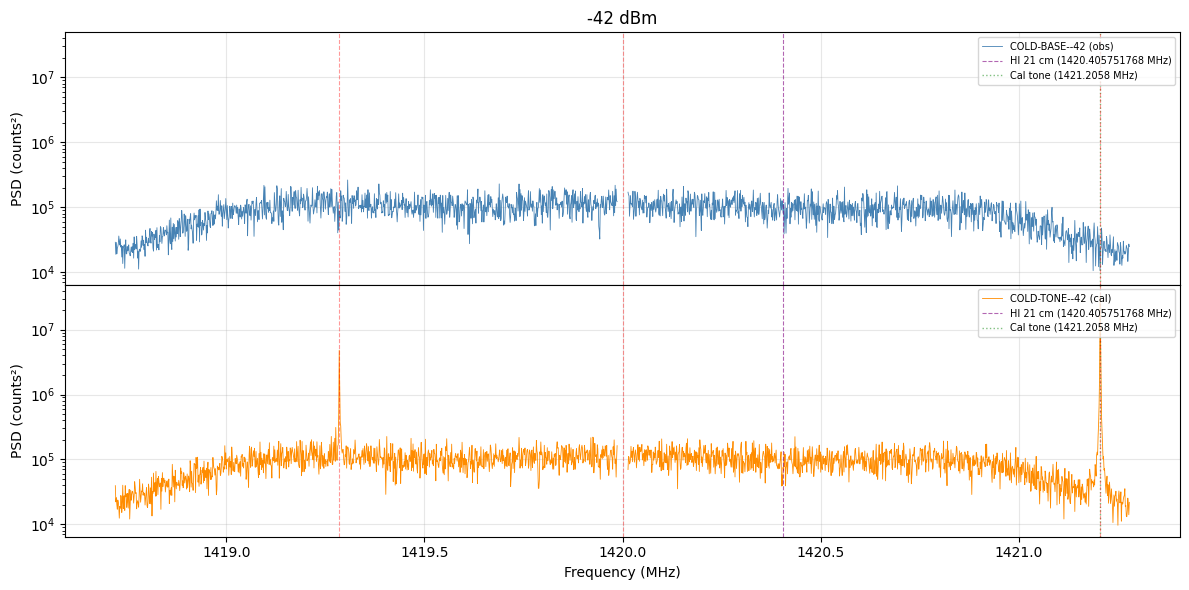

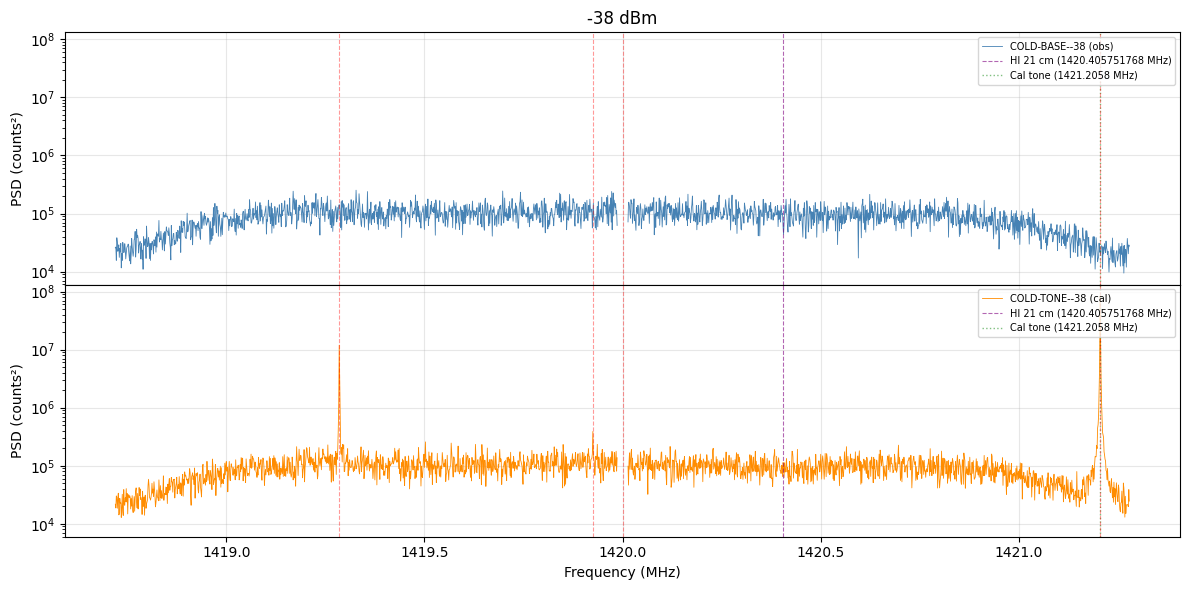

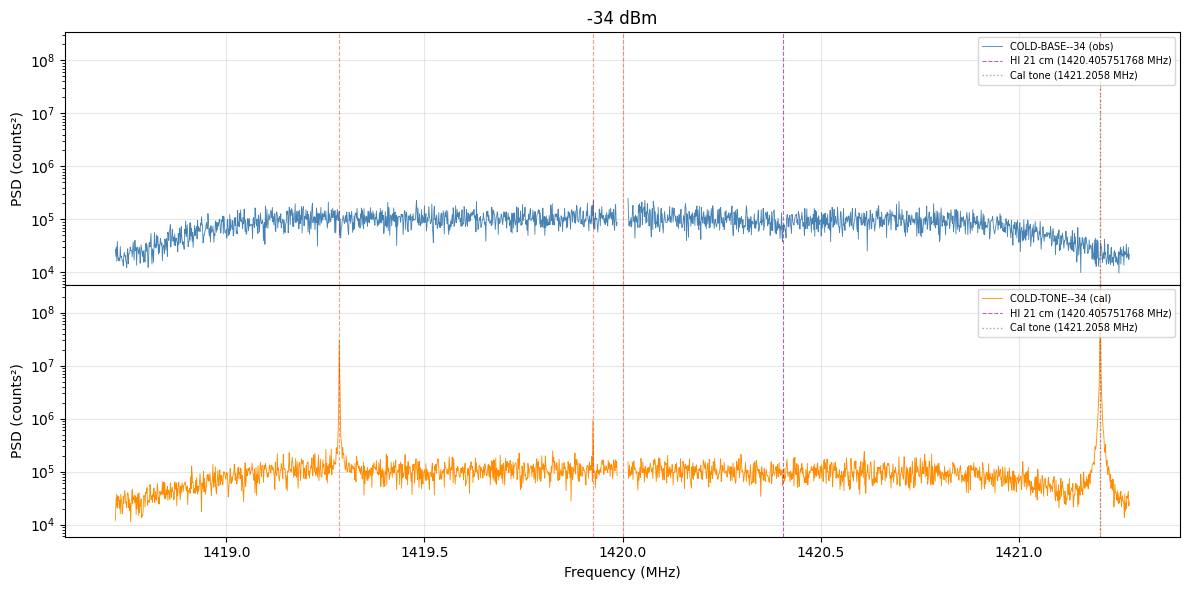

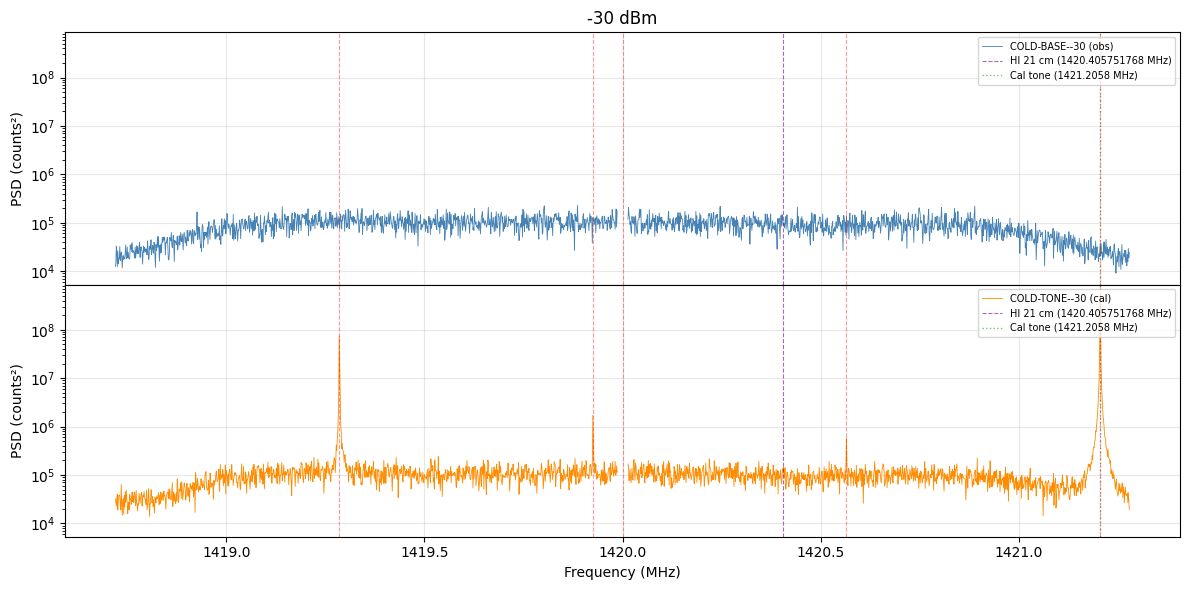

In [5]:
HI_FREQ = 1420.405751768
CAL_TONE_MHZ = 1421.2058
LO_HALF_WIDTH = 10  # bins to blank around the LO/DC peak

for dbm in paired_dbm:
    obs_spec = df.loc[df['prefix'] == f'COLD-BASE-{dbm}', 'spec'].values[0]
    cal_spec = df.loc[df['prefix'] == f'COLD-TONE-{dbm}', 'spec'].values[0]

    # Blank the LO leakage spike at the centre frequency
    dc_bin = obs_spec.bin_at(obs_spec.record.center_freq)
    lo_mask = np.ones(len(obs_spec.psd), dtype=bool)
    lo_mask[max(0, dc_bin - LO_HALF_WIDTH):dc_bin + LO_HALF_WIDTH + 1] = False
    obs_psd = np.where(lo_mask, obs_spec.psd, np.nan)
    cal_psd = np.where(lo_mask, cal_spec.psd, np.nan)

    obs_peaks = obs_spec.find_peaks()
    cal_peaks = cal_spec.find_peaks()
    all_peak_freqs = sorted({round(p['freq_mhz'], 3) for p in obs_peaks + cal_peaks})

    fig, (ax_obs, ax_cal) = plt.subplots(
        2, 1, sharex=True, sharey=True, figsize=(12, 6),
        gridspec_kw={'hspace': 0},
    )

    ax_obs.semilogy(obs_spec.freqs_mhz, obs_psd, lw=0.6,
                    color='steelblue', label=f'COLD-BASE-{dbm} (obs)')
    ax_cal.semilogy(cal_spec.freqs_mhz, cal_psd, lw=0.6,
                    color='darkorange', label=f'COLD-TONE-{dbm} (cal)')

    for ax in (ax_obs, ax_cal):
        ax.axvline(HI_FREQ, color='purple', ls='--', lw=0.8, alpha=0.6,
                   label=f'HI 21 cm ({HI_FREQ} MHz)')
        ax.axvline(CAL_TONE_MHZ, color='green', ls=':', lw=1.0, alpha=0.5,
                   label=f'Cal tone ({CAL_TONE_MHZ} MHz)')
        for f in all_peak_freqs:
            ax.axvline(f, color='red', ls='--', lw=0.8, alpha=0.4)
        ax.set_ylabel('PSD (counts²)')
        ax.legend(loc='upper right', fontsize=7)
        ax.grid(True, alpha=0.3)

    ax_obs.tick_params(bottom=False)

    ax_obs.set_title(f'{dbm} dBm')
    ax_cal.set_xlabel('Frequency (MHz)')

    fig.tight_layout()
    plt.show()

In [6]:
tone_freq_mhz = 1421.2058

stats_rows = []
for dbm in paired_dbm:
    tone_spec = df.loc[df['prefix'] == f'COLD-TONE-{dbm}', 'spec'].values[0]
    base_spec = df.loc[df['prefix'] == f'COLD-BASE-{dbm}', 'spec'].values[0]

    tone_bin = tone_spec.bin_at(tone_freq_mhz * 1e6)

    stats_rows.append({
        'siggen_amp_dBm': dbm,
        'tone_peak_psd': tone_spec.psd[tone_bin],
        'base_psd_at_tone': base_spec.psd[tone_bin],
        'tone_total_psd': tone_spec.total_power,
        'base_total_psd': base_spec.total_power,
        'tone_mean_psd': np.mean(tone_spec.psd),
        'base_mean_psd': np.mean(base_spec.psd),
        'tone_peak_freq_mhz': tone_spec.freqs_mhz[np.argmax(tone_spec.psd)],
        'peak_snr_dB': 10 * np.log10(
            tone_spec.psd[tone_bin] / base_spec.psd[tone_bin]
        ),
    })

psd_stats = pd.DataFrame(stats_rows)
psd_stats

,siggen_amp_dBm,tone_peak_psd,base_psd_at_tone,tone_total_psd,base_total_psd,tone_mean_psd,base_mean_psd,tone_peak_freq_mhz,peak_snr_dB
0,-50,1.175910e+06,16663.242525,2.031682e+08,191467929.6,99203.2,93490.2,1421.205,18.486146
1,-46,2.817068e+06,29779.230592,2.167011e+08,187589222.4,105811.1,91596.3,1421.205,19.758838
2,-42,7.406017e+06,23435.322237,2.461045e+08,190658560.0,120168.2,93095.0,1421.205,24.997138
3,-38,1.804170e+07,19823.520663,3.236819e+08,187748352.0,158047.8,91674.0,1421.205,29.590966
4,-34,4.675030e+07,35640.433710,5.254963e+08,186039500.8,256590.0,90839.6,1421.205,31.178414
5,-30,1.192463e+08,20299.862755,1.018540e+09,183073382.4,497333.9,89391.3,1421.205,37.689518


In [7]:
peak_rows = []
for _, row in df.iterrows():
    for p in row['spec'].find_peaks():
        peak_rows.append({
            'prefix': row['prefix'],
            'type': row['type'],
            'siggen_amp': row['siggen_amp'] if row['type'] == 'cal' else np.nan,
            **p,
        })

peaks_df = pd.DataFrame(peak_rows)
print(f'Found {len(peaks_df)} significant peaks across all captures\n')

if len(peaks_df) > 0:
    peaks_df['freq_rounded'] = peaks_df['freq_mhz'].round(3)
    print('Peak frequency summary (all captures):')
    freq_counts = peaks_df.groupby('freq_rounded').agg(
        count=('prefix', 'count'),
        in_cal=('type', lambda x: (x == 'cal').sum()),
        in_obs=('type', lambda x: (x == 'obs').sum()),
        max_snr_dB=('snr_over_median_dB', 'max'),
        mean_snr_dB=('snr_over_median_dB', 'mean'),
    ).sort_values('count', ascending=False)
    print(freq_counts.to_string())
    print()

peaks_df

Found 30 significant peaks across all captures

Peak frequency summary (all captures):
              count  in_cal  in_obs  max_snr_dB  mean_snr_dB
freq_rounded                                                
1420.000         14       6       8   16.233223    15.728289
1419.285          6       6       0   28.878904    19.210574
1421.205          6       6       0   37.152711    27.551792
1419.925          3       3       0   12.520326     9.635718
1420.565          1       1       0    7.875833     7.875833



,prefix,type,siggen_amp,freq_hz,freq_mhz,psd,prominence,snr_over_median_dB,freq_rounded
0,COLD-BASE-PRE,obs,NaN,1.420000e+09,1420.000,3.078440e+06,3.067666e+06,15.313592,1420.000
1,COLD-TONE--50,cal,-50.0,1.419285e+09,1419.285,8.721027e+05,8.368269e+05,9.723711,1419.285
2,COLD-TONE--50,cal,-50.0,1.420000e+09,1420.000,3.582902e+06,3.570282e+06,15.860384,1420.000
3,COLD-TONE--50,cal,-50.0,1.421205e+09,1421.205,5.677901e+06,5.665877e+06,17.859913,1421.205
4,COLD-BASE--50,obs,NaN,1.420000e+09,1420.000,3.062389e+06,3.050614e+06,15.287493,1420.000
5,COLD-TONE--46,cal,-46.0,1.419285e+09,1419.285,1.951685e+06,1.920523e+06,13.223627,1419.285
6,COLD-TONE--46,cal,-46.0,1.420000e+09,1420.000,3.708199e+06,3.692589e+06,16.011159,1420.000
7,COLD-TONE--46,cal,-46.0,1.421205e+09,1421.205,1.349258e+07,1.348249e+07,21.620480,1421.205
8,COLD-BASE--46,obs,NaN,1.420000e+09,1420.000,3.729760e+06,3.719453e+06,16.220016,1420.000
9,COLD-TONE--42,cal,-42.0,1.419285e+09,1419.285,4.817204e+06,4.805113e+06,17.189271,1419.285


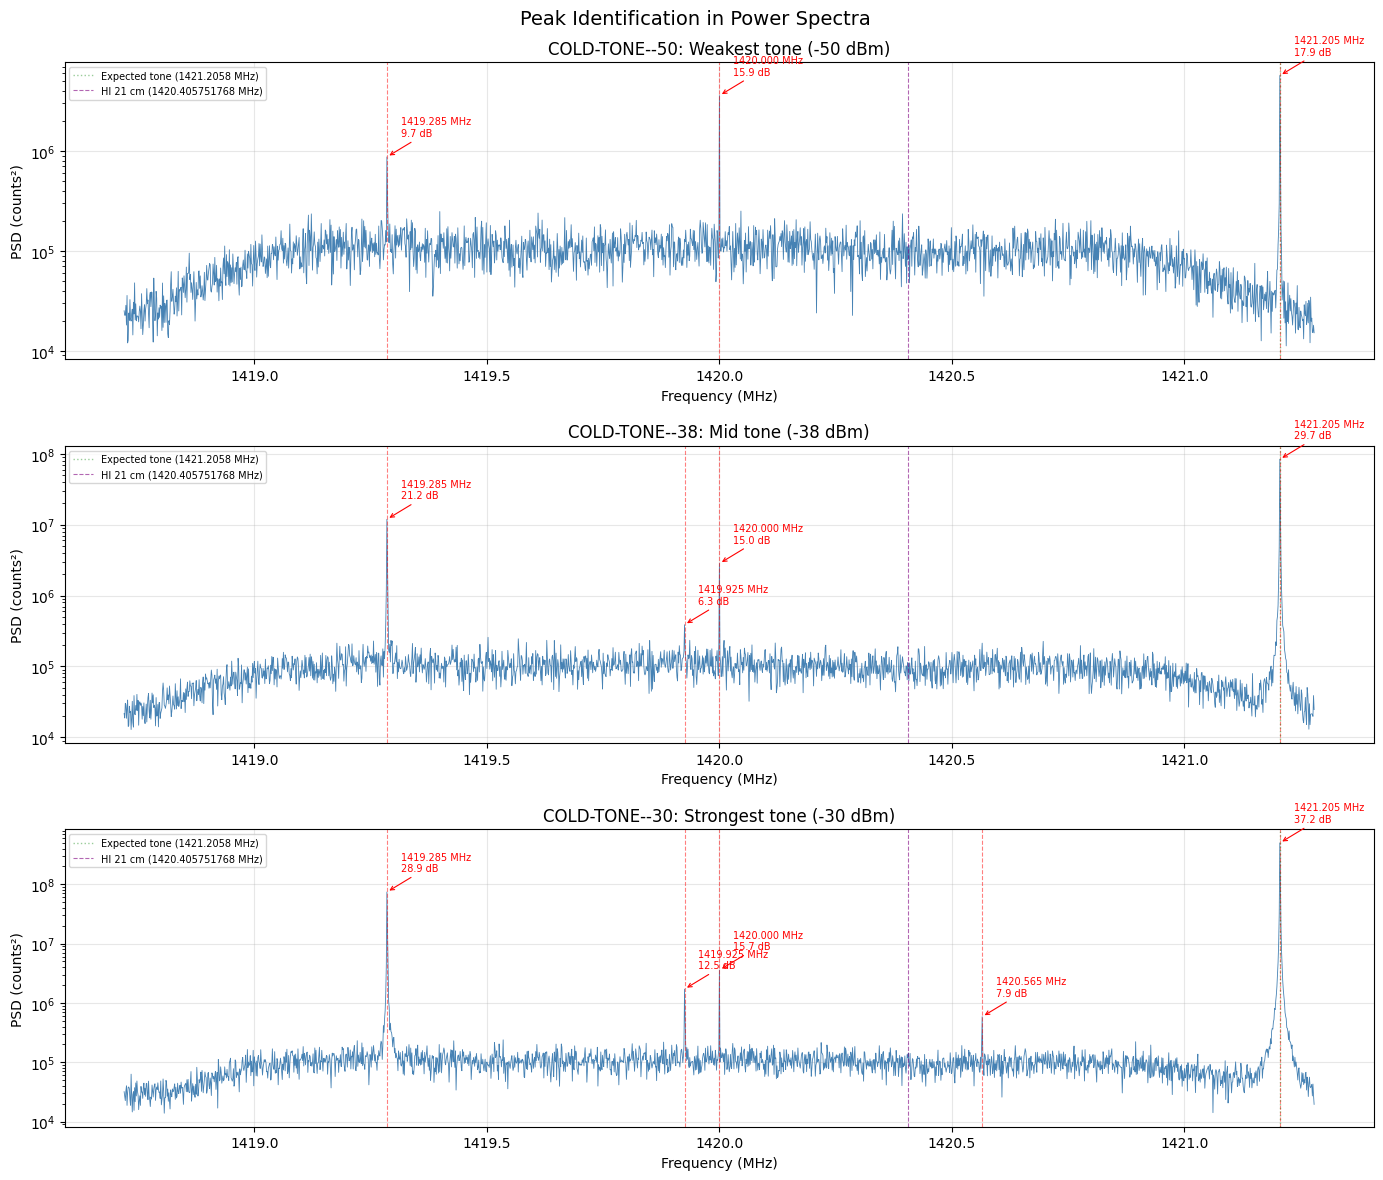

In [8]:
# Pick three tone levels: weakest, middle, strongest
tone_keys = [f'COLD-TONE-{d}' for d in paired_dbm]
examples = [
    (tone_keys[0],  f'Weakest tone ({paired_dbm[0]} dBm)'),
    (tone_keys[len(tone_keys) // 2], f'Mid tone ({paired_dbm[len(paired_dbm) // 2]} dBm)'),
    (tone_keys[-1], f'Strongest tone ({paired_dbm[-1]} dBm)'),
]

fig, axes = plt.subplots(len(examples), 1, figsize=(14, 4 * len(examples)))
axes = np.atleast_1d(axes)

for ax, (key, title) in zip(axes, examples):
    spec = df.loc[df['prefix'] == key, 'spec'].values[0]

    ax.semilogy(spec.freqs_mhz, spec.psd, lw=0.6, color='steelblue')

    for p in spec.find_peaks():
        ax.axvline(p['freq_mhz'], color='red', alpha=0.5, lw=0.8, ls='--')
        ax.annotate(
            f"{p['freq_mhz']:.3f} MHz\n{p['snr_over_median_dB']:.1f} dB",
            xy=(p['freq_mhz'], p['psd']),
            xytext=(10, 15), textcoords='offset points',
            fontsize=7, color='red',
            arrowprops=dict(arrowstyle='->', color='red', lw=0.8),
        )

    ax.axvline(tone_freq_mhz, color='green', alpha=0.4, lw=1, ls=':',
               label=f'Expected tone ({tone_freq_mhz} MHz)')
    ax.axvline(HI_FREQ, color='purple', alpha=0.6, lw=0.8, ls='--',
               label=f'HI 21 cm ({HI_FREQ} MHz)')
    ax.set_ylabel('PSD (counts²)')
    ax.set_xlabel('Frequency (MHz)')
    ax.set_title(f'{key}: {title}')
    ax.legend(loc='upper left', fontsize=7)
    ax.grid(True, alpha=0.3)

fig.suptitle('Peak Identification in Power Spectra', fontsize=14)
plt.tight_layout()
plt.show()

In [9]:
sub_rows = []
for dbm in paired_dbm:
    tone_spec = df.loc[df['prefix'] == f'COLD-TONE-{dbm}', 'spec'].values[0]
    base_spec = df.loc[df['prefix'] == f'COLD-BASE-{dbm}', 'spec'].values[0]

    diff_psd = tone_spec.psd - base_spec.psd
    tone_bin = tone_spec.bin_at(tone_freq_mhz * 1e6)

    sub_rows.append({
        'siggen_amp_dBm': dbm,
        'freqs_mhz': tone_spec.freqs_mhz,
        'diff_psd': diff_psd,
        'tone_bin_diff': diff_psd[tone_bin],
        'tone_bin_psd_cal': tone_spec.psd[tone_bin],
        'tone_bin_psd_base': base_spec.psd[tone_bin],
        'total_diff': tone_spec.total_power - base_spec.total_power,
        'mean_diff': np.mean(diff_psd),
    })

sub_df = pd.DataFrame(sub_rows)

print('Baseline-subtracted tone power at 1421.205 MHz:')
print(sub_df[['siggen_amp_dBm', 'tone_bin_psd_cal', 'tone_bin_psd_base',
              'tone_bin_diff', 'total_diff', 'mean_diff']].to_string(index=False))

Baseline-subtracted tone power at 1421.205 MHz:
 siggen_amp_dBm  tone_bin_psd_cal  tone_bin_psd_base  tone_bin_diff  total_diff  mean_diff
            -50      1.175910e+06       16663.242525   1.159247e+06  11700224.0     5713.0
            -46      2.817068e+06       29779.230592   2.787288e+06  29111910.4    14214.8
            -42      7.406017e+06       23435.322237   7.382581e+06  55445913.6    27073.2
            -38      1.804170e+07       19823.520663   1.802187e+07 135933542.4    66373.8
            -34      4.675030e+07       35640.433710   4.671466e+07 339456819.2   165750.4
            -30      1.192463e+08       20299.862755   1.192260e+08 835466444.8   407942.6


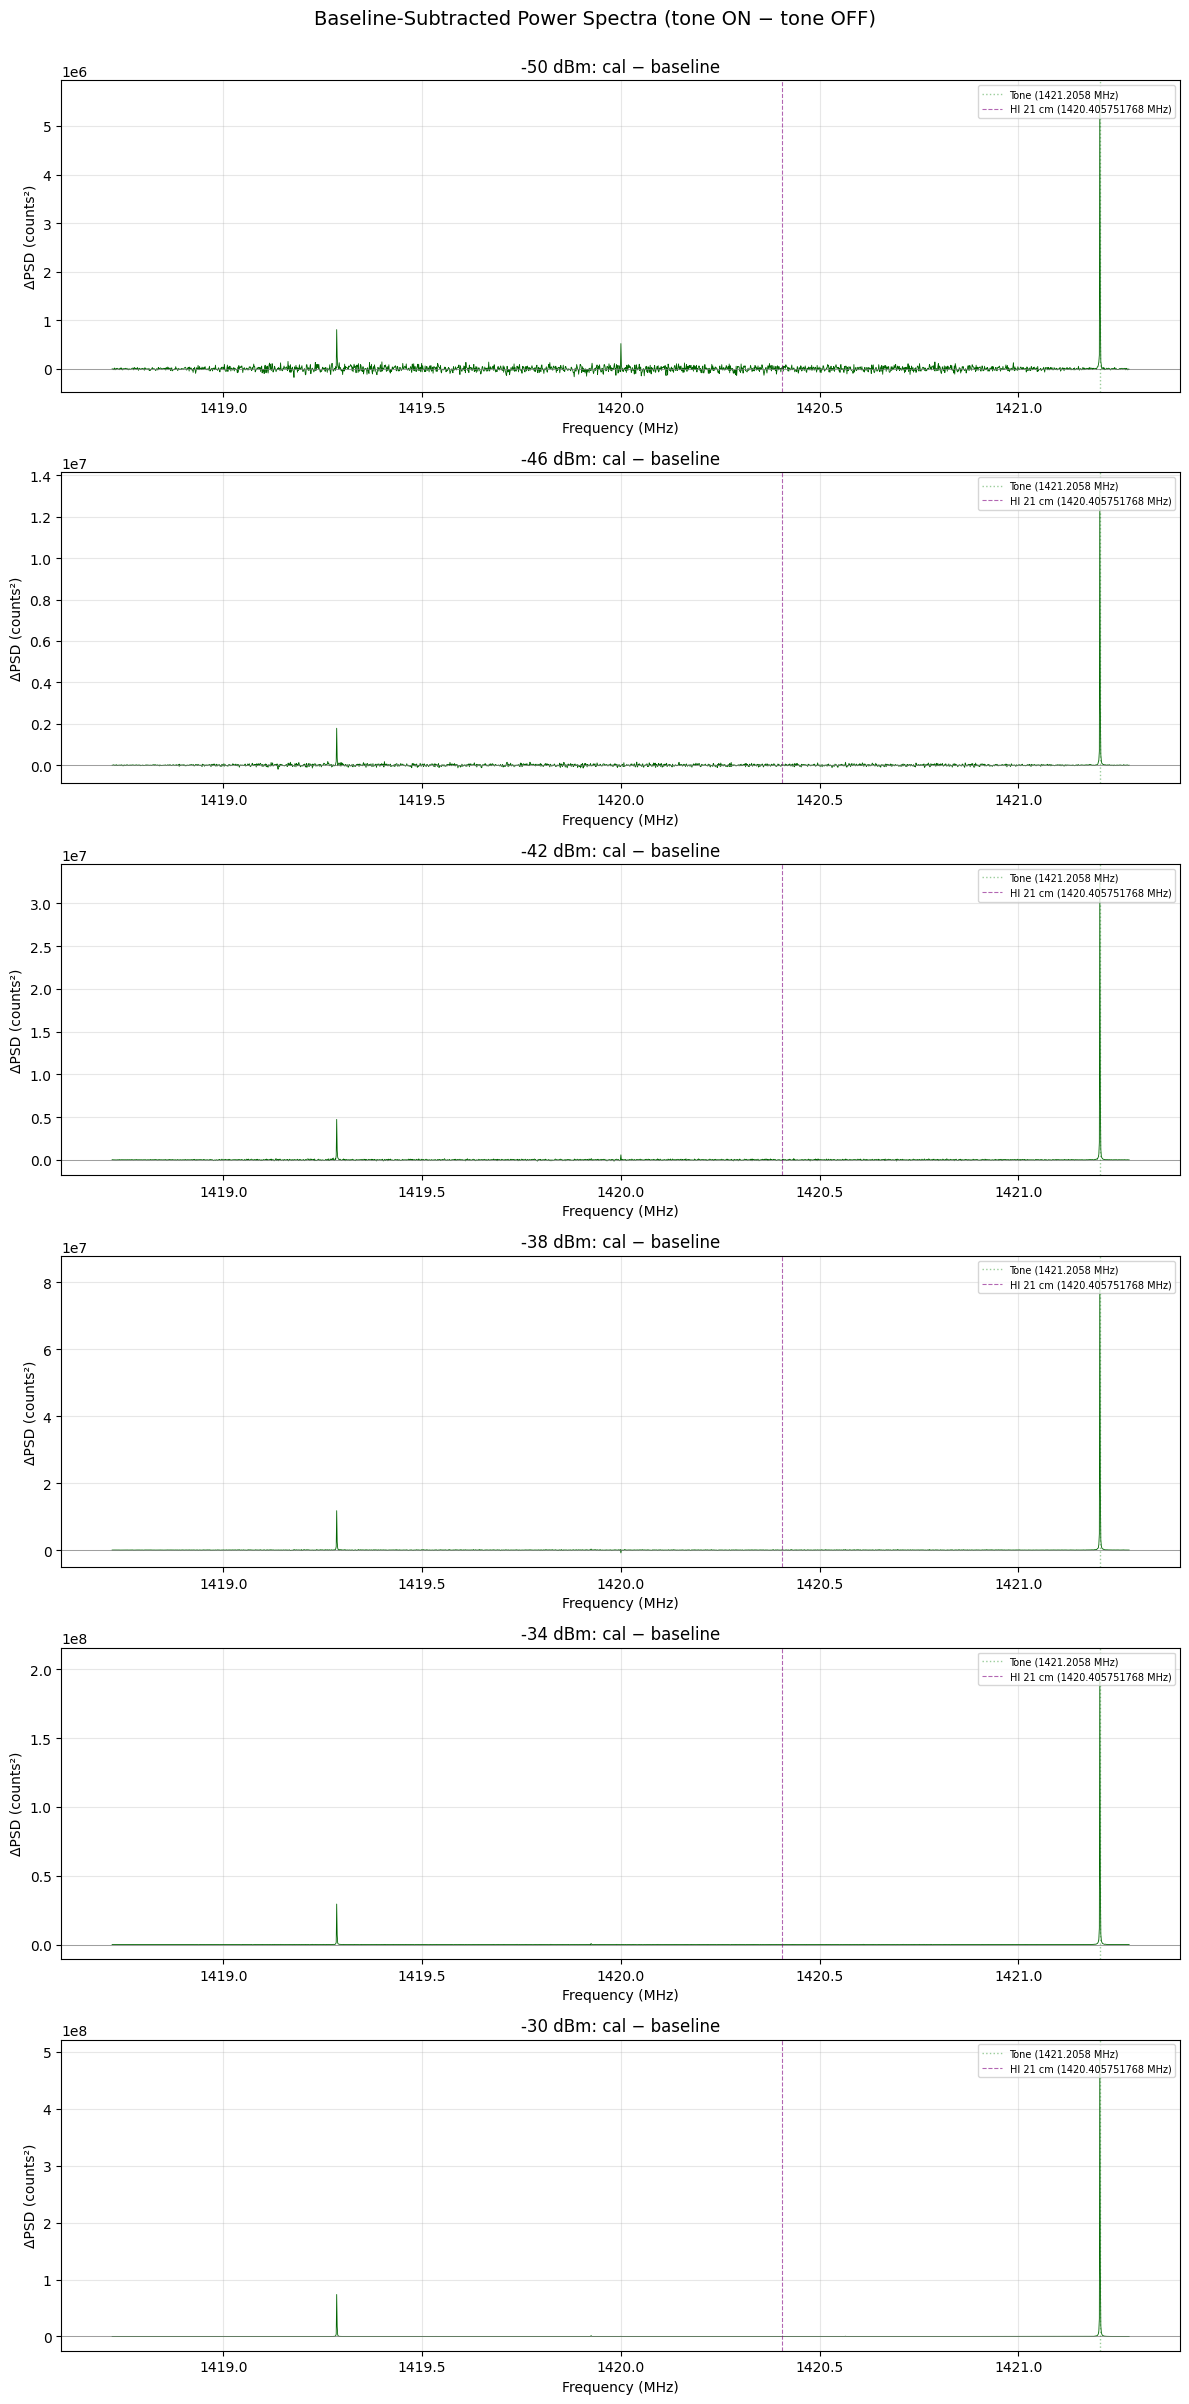

In [10]:
# Baseline-subtracted spectra (cal - obs) for each available dBm level
fig, axes = plt.subplots(len(sub_df), 1, figsize=(12, 4 * len(sub_df)))
axes = np.atleast_1d(axes)

for i, row in sub_df.iterrows():
    ax = axes[i]
    dbm = row['siggen_amp_dBm']
    freqs = row['freqs_mhz']
    diff = row['diff_psd']

    ax.plot(freqs, diff, lw=0.6, color='darkgreen')
    ax.axhline(0, color='gray', lw=0.5, ls='-')
    ax.axvline(tone_freq_mhz, color='green', alpha=0.4, lw=1, ls=':',
               label=f'Tone ({tone_freq_mhz} MHz)')
    ax.axvline(HI_FREQ, color='purple', alpha=0.6, lw=0.8, ls='--',
               label=f'HI 21 cm ({HI_FREQ} MHz)')
    ax.set_ylabel('ΔPSD (counts²)')
    ax.set_xlabel('Frequency (MHz)')
    ax.set_title(f'{int(dbm)} dBm: cal − baseline')
    ax.legend(loc='upper right', fontsize=7)
    ax.grid(True, alpha=0.3)

fig.suptitle('Baseline-Subtracted Power Spectra (tone ON − tone OFF)', fontsize=14, y=1.0)
plt.tight_layout()
plt.show()



In [11]:
# Baseline-subtracted statistics DataFrame
sub_stats = sub_df[['siggen_amp_dBm', 'tone_bin_diff', 'total_diff', 'mean_diff']].copy()
sub_stats['tone_diff_dB'] = 10 * np.log10(np.abs(sub_stats['tone_bin_diff']))
sub_stats['tone_diff_positive'] = sub_stats['tone_bin_diff'] > 0
sub_stats

,siggen_amp_dBm,tone_bin_diff,total_diff,mean_diff,tone_diff_dB,tone_diff_positive
0,-50,1.159247e+06,11700224.0,5713.0,60.641759,True
1,-46,2.787288e+06,29111910.4,14214.8,64.451819,True
2,-42,7.382581e+06,55445913.6,27073.2,68.682082,True
3,-38,1.802187e+07,135933542.4,66373.8,72.558000,True
4,-34,4.671466e+07,339456819.2,165750.4,76.694532,True
5,-30,1.192260e+08,835466444.8,407942.6,80.763709,True


In [12]:
# --- Step 4: Linearity check ---
# Plot measured tone power vs input power (dBm).
# On a dB-vs-dB scale, a linear receiver should give slope ≈ 1.

from scipy.stats import linregress

# Use baseline-subtracted tone power at the tone bin
input_dbm = sub_df['siggen_amp_dBm'].values.astype(float)
tone_power = sub_df['tone_bin_diff'].values.astype(float)

# Also use total integrated power difference (more robust)
total_diff = sub_df['total_diff'].values.astype(float)

# Only fit where tone_bin_diff > 0 (tone is detectable above noise)
mask = tone_power > 0
input_fit = input_dbm[mask]
tone_power_fit = tone_power[mask]
tone_power_db = 10 * np.log10(tone_power_fit)

# Linear regression on dB vs dBm
slope, intercept, r_value, p_value, std_err = linregress(input_fit, tone_power_db)

print(f'Linearity fit (baseline-subtracted tone bin):')
print(f'  Points used: {mask.sum()} / {len(mask)} (where cal > base)')
print(f'  Slope:     {slope:.4f} dB/dBm  (ideal = 1.0)')
print(f'  Intercept: {intercept:.2f} dB')
print(f'  R²:        {r_value**2:.6f}')
print(f'  Std error: {std_err:.4f}')
print()

# Also fit total integrated power
mask_total = total_diff > 0
input_fit_t = input_dbm[mask_total]
total_db = 10 * np.log10(total_diff[mask_total])
slope_t, intercept_t, r_t, _, stderr_t = linregress(input_fit_t, total_db)

print(f'Linearity fit (total integrated power diff):')
print(f'  Points used: {mask_total.sum()} / {len(mask_total)}')
print(f'  Slope:     {slope_t:.4f} dB/dBm  (ideal = 1.0)')
print(f'  Intercept: {intercept_t:.2f} dB')
print(f'  R²:        {r_t**2:.6f}')

Linearity fit (baseline-subtracted tone bin):
  Points used: 6 / 6 (where cal > base)
  Slope:     1.0087 dB/dBm  (ideal = 1.0)
  Intercept: 110.98 dB
  R²:        0.999857
  Std error: 0.0060

Linearity fit (total integrated power diff):
  Points used: 6 / 6
  Slope:     0.9184 dB/dBm  (ideal = 1.0)
  Intercept: 116.51 dB
  R²:        0.997698


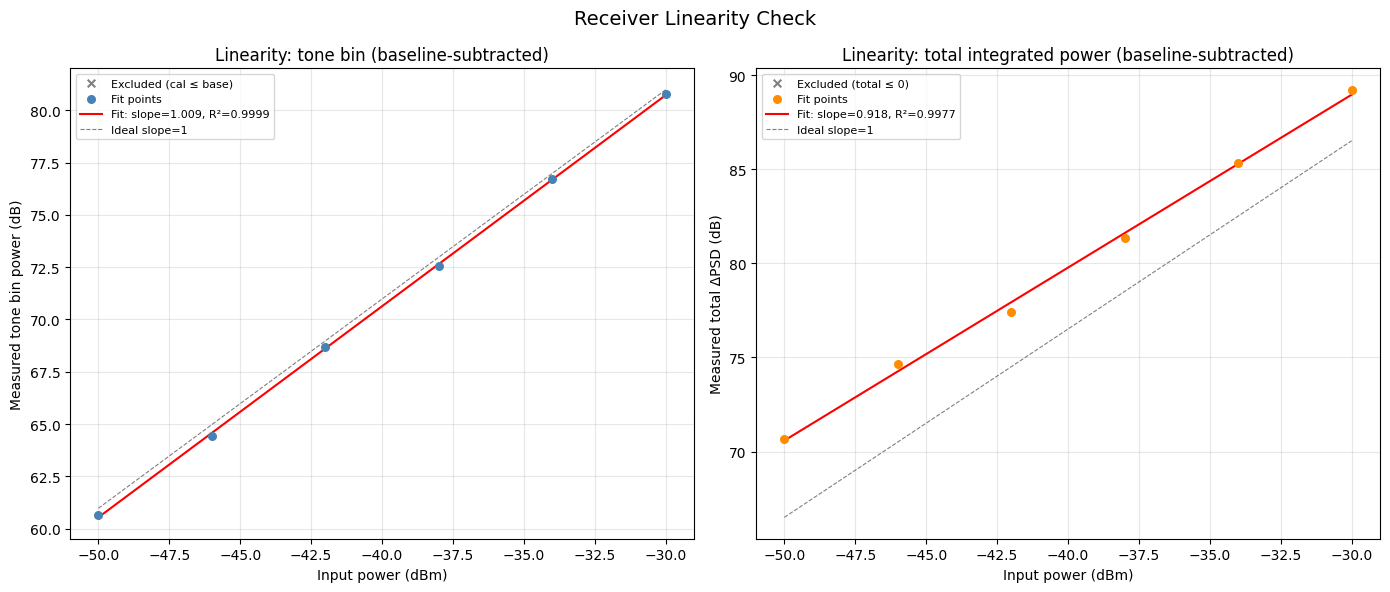

In [13]:
# Linearity plot: measured output power (dB) vs input power (dBm)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# --- Left: tone bin power ---
# Plot all points, color by whether they were included in the fit
ax1.scatter(input_dbm[~mask], 10 * np.log10(np.abs(tone_power[~mask])),
            marker='x', color='gray', s=30, label='Excluded (cal ≤ base)', zorder=3)
ax1.scatter(input_fit, tone_power_db,
            marker='o', color='steelblue', s=30, label='Fit points', zorder=3)

# Fit line
x_line = np.linspace(input_fit.min(), input_fit.max(), 100)
ax1.plot(x_line, slope * x_line + intercept, 'r-', lw=1.5,
         label=f'Fit: slope={slope:.3f}, R²={r_value**2:.4f}')

# Ideal slope=1 reference
ax1.plot(x_line, 1.0 * x_line + intercept, 'k--', lw=0.8, alpha=0.5,
         label='Ideal slope=1')

ax1.set_xlabel('Input power (dBm)')
ax1.set_ylabel('Measured tone bin power (dB)')
ax1.set_title('Linearity: tone bin (baseline-subtracted)')
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3)

# --- Right: total integrated power ---
ax2.scatter(input_dbm[~mask_total], 10 * np.log10(np.abs(total_diff[~mask_total])),
            marker='x', color='gray', s=30, label='Excluded (total ≤ 0)', zorder=3)
ax2.scatter(input_fit_t, total_db,
            marker='o', color='darkorange', s=30, label='Fit points', zorder=3)

x_line_t = np.linspace(input_fit_t.min(), input_fit_t.max(), 100)
ax2.plot(x_line_t, slope_t * x_line_t + intercept_t, 'r-', lw=1.5,
         label=f'Fit: slope={slope_t:.3f}, R²={r_t**2:.4f}')
ax2.plot(x_line_t, 1.0 * x_line_t + intercept_t, 'k--', lw=0.8, alpha=0.5,
         label='Ideal slope=1')

ax2.set_xlabel('Input power (dBm)')
ax2.set_ylabel('Measured total ΔPSD (dB)')
ax2.set_title('Linearity: total integrated power (baseline-subtracted)')
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3)

fig.suptitle('Receiver Linearity Check', fontsize=14)
plt.tight_layout()
plt.show()

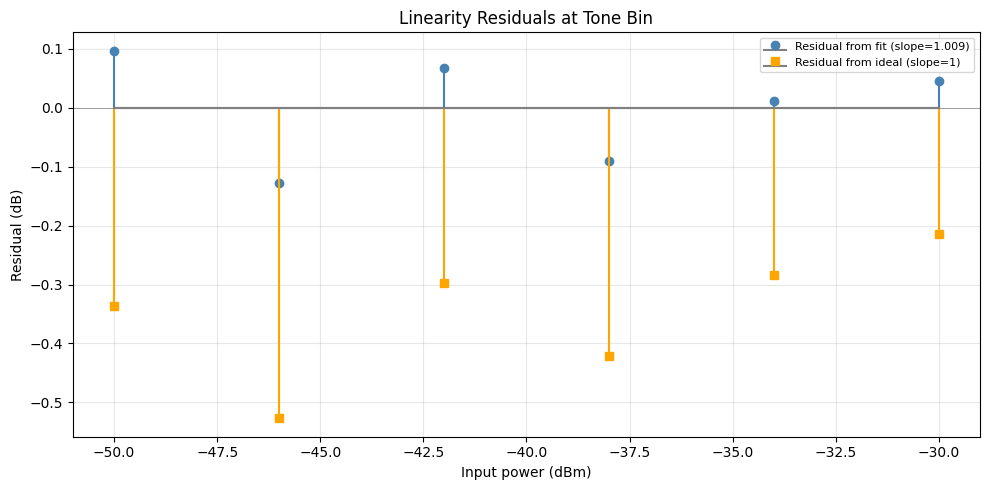

In [14]:
# Residuals from ideal linearity
fig, ax = plt.subplots(figsize=(10, 5))

residual = tone_power_db - (slope * input_fit + intercept)
ideal_residual = tone_power_db - (1.0 * input_fit + intercept)

ax.stem(input_fit, residual, linefmt='steelblue', markerfmt='o', basefmt='gray',
        label=f'Residual from fit (slope={slope:.3f})')
ax.stem(input_fit, ideal_residual, linefmt='orange', markerfmt='s', basefmt='gray',
        label='Residual from ideal (slope=1)')
ax.axhline(0, color='gray', lw=0.5)
ax.set_xlabel('Input power (dBm)')
ax.set_ylabel('Residual (dB)')
ax.set_title('Linearity Residuals at Tone Bin')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [15]:
# --- Step 5: Noise floor & system temperature ---
# Characterize the system noise from baseline-only captures.
# T_sys = P_noise / (k_B * B) where B = bandwidth per bin

k_B = 1.380649e-23  # Boltzmann constant (J/K)
spec0 = df['spec'].iloc[0]
sample_rate_hz = spec0.record.sample_rate
nsamples = spec0.record.data.shape[1]
bin_bw = sample_rate_hz / nsamples  # Hz per bin

# Collect noise statistics from all baseline (obs) captures
obs_df = df[df['type'] == 'obs'].copy()

noise_rows = []
for _, row in obs_df.iterrows():
    spec = row['spec']
    psd = spec.psd
    iq = spec.record.data

    # Exclude DC bin (center) and tone bin region for clean noise estimate
    freqs = spec.freqs_mhz
    dc_bin = np.argmin(np.abs(freqs - 1420.0))
    tone_bin = np.argmin(np.abs(freqs - tone_freq_mhz))

    # Mask: exclude ±5 bins around DC and tone
    mask = np.ones(len(psd), dtype=bool)
    mask[max(0, dc_bin-5):dc_bin+6] = False
    mask[max(0, tone_bin-5):tone_bin+6] = False

    clean_psd = psd[mask]

    # RMS voltage from time domain (complex IQ: mean |IQ|²)
    vrms = np.sqrt(np.mean(np.abs(iq)**2))

    noise_rows.append({
        'prefix': row['prefix'],
        'unix_time': row['unix_time'],
        'mean_psd': np.mean(clean_psd),
        'median_psd': np.median(clean_psd),
        'std_psd': np.std(clean_psd),
        'total_power': spec.total_power,
        'vrms': vrms,
    })

noise_df = pd.DataFrame(noise_rows)

print('Baseline noise statistics (obs captures, excluding DC & tone bins):')
print(f'  Mean PSD across baselines:   {noise_df["mean_psd"].mean():.1f} counts²')
print(f'  Std of mean PSD:             {noise_df["mean_psd"].std():.1f} counts²')
print(f'  Mean Vrms:                   {noise_df["vrms"].mean():.2f} counts')
print(f'  Bin bandwidth:               {bin_bw:.1f} Hz')
print(f'  Total bandwidth:             {sample_rate_hz/1e6:.2f} MHz')
print()
noise_df

Baseline noise statistics (obs captures, excluding DC & tone bins):
  Mean PSD across baselines:   90438.1 counts²
  Std of mean PSD:             1610.8 counts²
  Mean Vrms:                   6.70 counts
  Bin bandwidth:               1250.0 Hz
  Total bandwidth:             2.56 MHz



,prefix,unix_time,mean_psd,median_psd,std_psd,total_power,vrms
0,COLD-BASE-PRE,1.771289e+09,92544.207918,90610.168505,41728.016553,192133734.4,6.768179
1,COLD-BASE--50,1.771289e+09,92266.848546,90669.886549,42344.709837,191467929.6,6.756442
2,COLD-BASE--46,1.771289e+09,90002.475554,89335.787360,39863.326065,187589222.4,6.687657
3,COLD-BASE--42,1.771289e+09,91827.824520,90481.070743,41664.362256,190658560.0,6.742147
4,COLD-BASE--38,1.771289e+09,90073.545540,87994.949820,40758.367043,187748352.0,6.690493
5,COLD-BASE--34,1.771289e+09,89516.176985,87711.882878,40009.017287,186039500.8,6.659975
6,COLD-BASE--30,1.771289e+09,88008.324292,87103.858481,39348.961324,183073382.4,6.606671
7,COLD-BASE-POST,1.771289e+09,89265.147017,87913.763457,39542.127509,185651609.6,6.653029


In [16]:
# System temperature estimate using the calibration slope
# From step 4, we have: measured_dB = slope * input_dBm + intercept
# The noise floor in the same units lets us estimate T_sys.
#
# Method: use the linearity fit from total integrated power (more robust).
# At the noise floor (no tone), the total power is just system noise.
# P_noise (counts²) = mean baseline total_power
# P_tone (counts²) at known input → calibration factor counts²/Watt
# T_sys = P_noise / (cal_factor * k_B * B)

# Use a high-SNR cal point for calibration (e.g. -30 dBm)
cal_dbm = -30.0
cal_row = sub_df.loc[sub_df['siggen_amp_dBm'] == cal_dbm].iloc[0]
cal_power_watts = 10**((cal_dbm) / 10) * 1e-3  # dBm to Watts

# Baseline-subtracted total power at this level = counts² from the tone alone
cal_counts2 = cal_row['total_diff']

# Calibration factor: counts² per Watt
cal_factor = cal_counts2 / cal_power_watts

# Mean noise floor from baselines (total power)
mean_noise_counts2 = noise_df['total_power'].mean()

# Noise power in Watts
noise_watts = mean_noise_counts2 / cal_factor

# System temperature: P = k_B * T * B
T_sys = noise_watts / (k_B * sample_rate_hz)

print(f'Calibration reference: {cal_dbm} dBm = {cal_power_watts:.2e} W')
print(f'  Baseline-subtracted counts²: {cal_counts2:.3e}')
print(f'  Calibration factor: {cal_factor:.3e} counts²/W')
print()
print(f'Mean baseline noise:')
print(f'  Total PSD: {mean_noise_counts2:.3e} counts²')
print(f'  Equivalent power: {noise_watts:.3e} W')
print()
print(f'System temperature estimate:')
print(f'  T_sys = {T_sys:.0f} K')
print()
print('Note: This is a rough estimate. The ADC quantization, gain chain,')
print('and impedance matching all affect the absolute calibration.')

Calibration reference: -30.0 dBm = 1.00e-06 W
  Baseline-subtracted counts²: 8.355e+08
  Calibration factor: 8.355e+14 counts²/W

Mean baseline noise:
  Total PSD: 1.880e+08 counts²
  Equivalent power: 2.251e-07 W

System temperature estimate:
  T_sys = 6368104653 K

Note: This is a rough estimate. The ADC quantization, gain chain,
and impedance matching all affect the absolute calibration.


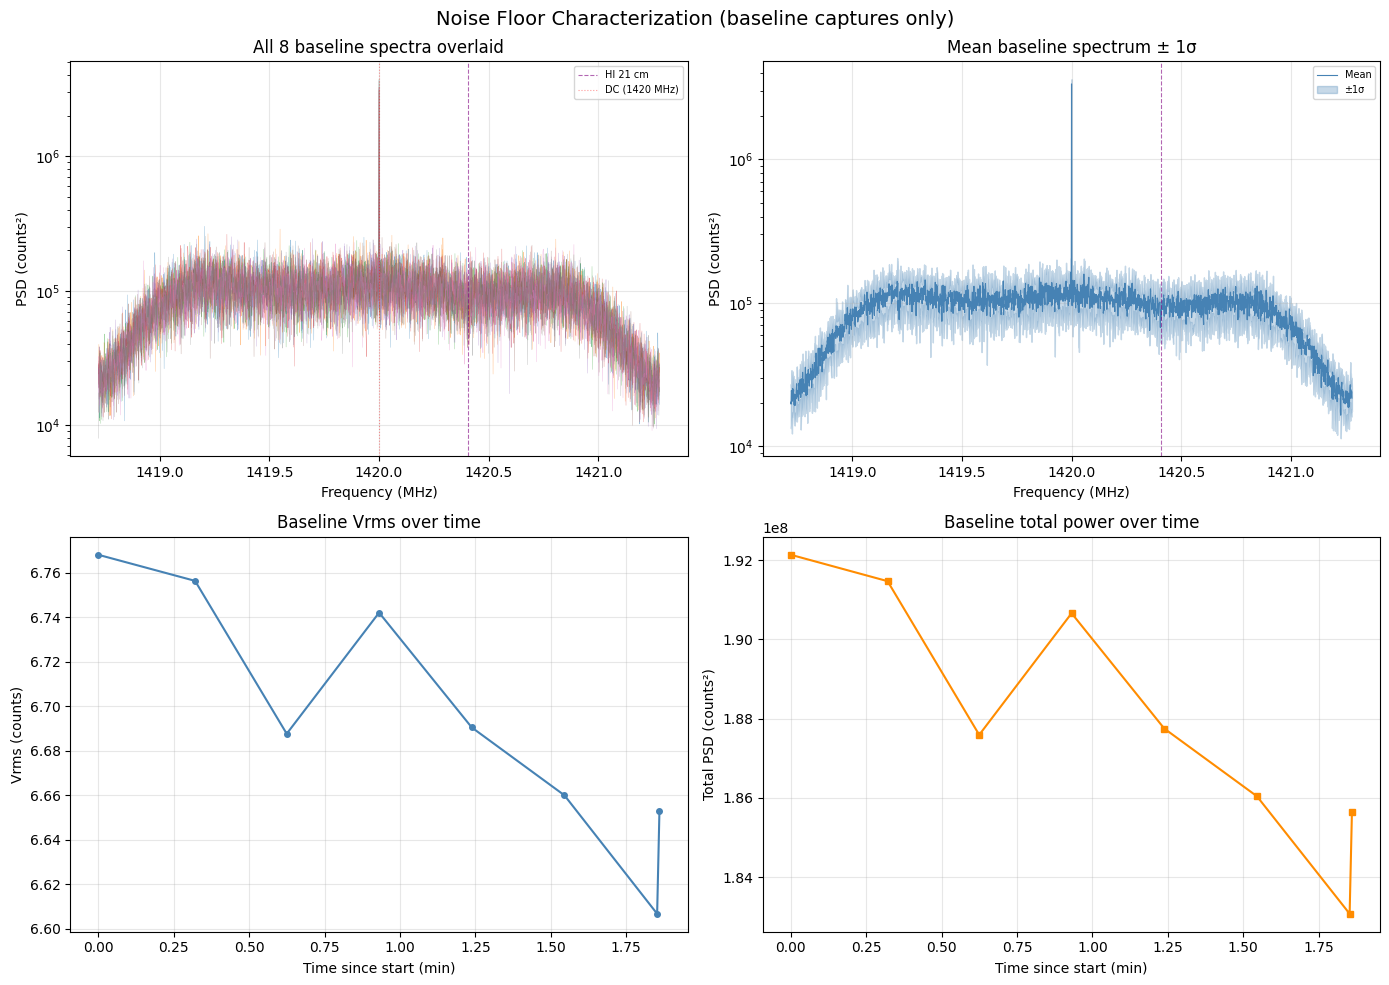

In [17]:
# Noise floor visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Top-left: overlay all baseline spectra
ax = axes[0, 0]
for _, row in obs_df.iterrows():
    ax.semilogy(row['spec'].freqs_mhz, row['spec'].psd, lw=0.3, alpha=0.5)
ax.axvline(HI_FREQ, color='purple', alpha=0.6, lw=0.8, ls='--', label='HI 21 cm')
ax.axvline(1420.0, color='red', alpha=0.4, lw=0.8, ls=':', label='DC (1420 MHz)')
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('PSD (counts²)')
ax.set_title(f'All {len(obs_df)} baseline spectra overlaid')
ax.legend(fontsize=7)
ax.grid(True, alpha=0.3)

# Top-right: mean ± std baseline spectrum
ax = axes[0, 1]
all_psd = np.array([row['spec'].psd for _, row in obs_df.iterrows()])
mean_psd = np.mean(all_psd, axis=0)
std_psd = np.std(all_psd, axis=0)
freqs = obs_df.iloc[0]['spec'].freqs_mhz
ax.semilogy(freqs, mean_psd, lw=0.8, color='steelblue', label='Mean')
ax.fill_between(freqs, mean_psd - std_psd, mean_psd + std_psd,
                alpha=0.3, color='steelblue', label='±1σ')
ax.axvline(HI_FREQ, color='purple', alpha=0.6, lw=0.8, ls='--')
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('PSD (counts²)')
ax.set_title('Mean baseline spectrum ± 1σ')
ax.legend(fontsize=7)
ax.grid(True, alpha=0.3)

# Bottom-left: noise Vrms over time
ax = axes[1, 0]
t_min = (noise_df['unix_time'] - noise_df['unix_time'].iloc[0]) / 60
ax.plot(t_min, noise_df['vrms'], 'o-', ms=4, color='steelblue')
ax.set_xlabel('Time since start (min)')
ax.set_ylabel('Vrms (counts)')
ax.set_title('Baseline Vrms over time')
ax.grid(True, alpha=0.3)

# Bottom-right: total power over time
ax = axes[1, 1]
ax.plot(t_min, noise_df['total_power'], 's-', ms=4, color='darkorange')
ax.set_xlabel('Time since start (min)')
ax.set_ylabel('Total PSD (counts²)')
ax.set_title('Baseline total power over time')
ax.grid(True, alpha=0.3)

fig.suptitle('Noise Floor Characterization (baseline captures only)', fontsize=14)
plt.tight_layout()
plt.show()

In [18]:
# --- Step 6: Drift check ---
# Quantify how the baseline total power drifts over the observation window.

# Elapsed time for baseline captures
t0 = noise_df['unix_time'].iloc[0]
noise_df['elapsed_min'] = (noise_df['unix_time'] - t0) / 60.0

# Elapsed time for cal captures (join via prefix → df unix_time)
cal_df = df[df['type'] == 'cal'].copy()
cal_df['elapsed_min'] = (cal_df['unix_time'] - t0) / 60.0
# Merge cal timestamps into psd_stats
psd_stats['elapsed_min'] = cal_df['elapsed_min'].values

# Linear fit to baseline total power vs time
slope_drift, intercept_drift, r_drift, _, stderr_drift = linregress(
    noise_df['elapsed_min'], noise_df['total_power']
)

window_min = noise_df['elapsed_min'].iloc[-1] - noise_df['elapsed_min'].iloc[0]
total_drift = slope_drift * window_min
pct_drift = 100 * total_drift / noise_df['total_power'].mean()

print('Baseline drift analysis:')
print(f'  Observation window:  {window_min:.1f} min')
print(f'  Drift rate:          {slope_drift:.2e} counts²/min')
print(f'  Total drift:         {total_drift:.2e} counts² ({pct_drift:.2f}% of mean)')
print(f'  R²:                  {r_drift**2:.4f}')
print(f'  Std error of slope:  {stderr_drift:.2e} counts²/min')

Baseline drift analysis:
  Observation window:  1.9 min
  Drift rate:          -4.07e+06 counts²/min
  Total drift:         -7.57e+06 counts² (-4.03% of mean)
  R²:                  0.8072
  Std error of slope:  8.12e+05 counts²/min


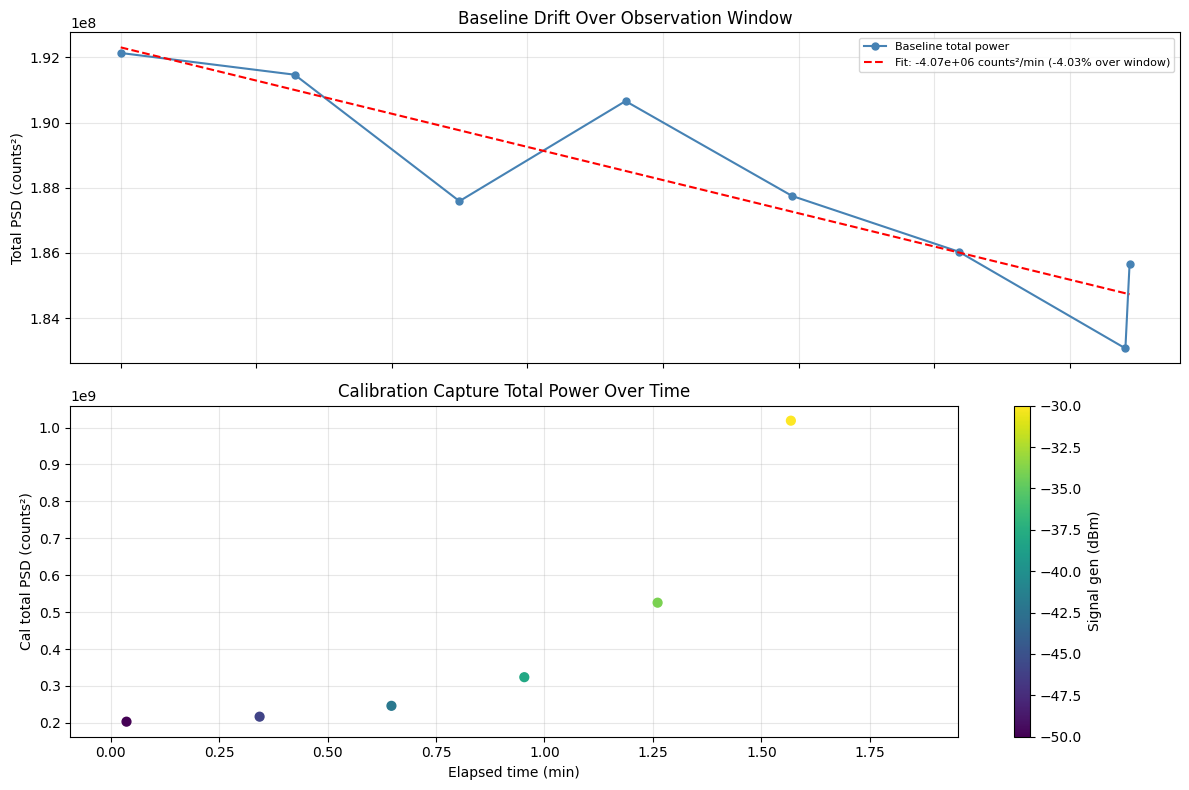

In [19]:
# Step 6 — Drift visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Top: baseline total power vs elapsed time + linear fit
ax1.plot(noise_df['elapsed_min'], noise_df['total_power'], 'o-', ms=5,
         color='steelblue', label='Baseline total power')
x_fit = np.linspace(noise_df['elapsed_min'].min(), noise_df['elapsed_min'].max(), 100)
ax1.plot(x_fit, slope_drift * x_fit + intercept_drift, 'r--', lw=1.5,
         label=f'Fit: {slope_drift:.2e} counts²/min ({pct_drift:+.2f}% over window)')
ax1.set_ylabel('Total PSD (counts²)')
ax1.set_title('Baseline Drift Over Observation Window')
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3)

# Bottom: cal total power vs elapsed time, colored by dBm
sc = ax2.scatter(psd_stats['elapsed_min'], psd_stats['tone_total_psd'],
                 c=psd_stats['siggen_amp_dBm'], cmap='viridis', s=40, zorder=3)
cbar = plt.colorbar(sc, ax=ax2)
cbar.set_label('Signal gen (dBm)')
ax2.set_ylabel('Cal total PSD (counts²)')
ax2.set_xlabel('Elapsed time (min)')
ax2.set_title('Calibration Capture Total Power Over Time')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [20]:
# --- Step 7: Build calibration curve ---
# Convert dBm → Watts, fit linear region, derive system temperature.

# Input power in Watts
sub_df['P_watts'] = 10**(sub_df['siggen_amp_dBm'] / 10) * 1e-3

# Identify linear region: total_diff must be well above the noise floor
noise_floor_std = noise_df['total_power'].std()
linear_mask = sub_df['total_diff'] > 3 * noise_floor_std

print(f'Noise floor std:       {noise_floor_std:.2e} counts²')
print(f'3σ threshold:          {3 * noise_floor_std:.2e} counts²')
print(f'Linear region points:  {linear_mask.sum()} / {len(sub_df)}')
print(f'Usable dBm range:      {sub_df.loc[linear_mask, "siggen_amp_dBm"].min():.0f} '
      f'to {sub_df.loc[linear_mask, "siggen_amp_dBm"].max():.0f} dBm')
print()

# Linear regression: Watts → counts² (total_diff)
P_lin = sub_df.loc[linear_mask, 'P_watts'].values
counts2_lin = sub_df.loc[linear_mask, 'total_diff'].values

slope_cal, intercept_cal, r_cal, _, stderr_cal = linregress(P_lin, counts2_lin)

print(f'Calibration fit (linear region):')
print(f'  Slope:               {slope_cal:.4e} counts²/W')
print(f'  Intercept:           {intercept_cal:.2e} counts²')
print(f'  R²:                  {r_cal**2:.6f}')
print(f'  Conversion factor:   {1/slope_cal:.4e} W/count²')
print()

# System temperature from calibration slope
mean_noise = noise_df['total_power'].mean()
T_sys_cal = mean_noise / (slope_cal * k_B * sample_rate_hz)

print(f'System temperature (from calibration curve):')
print(f'  Mean baseline power: {mean_noise:.3e} counts²')
print(f'  T_sys = {T_sys_cal:.0f} K')
print(f'  (Step 5 estimate:    {T_sys:.0f} K)')

Noise floor std:       3.16e+06 counts²
3σ threshold:          9.49e+06 counts²
Linear region points:  6 / 6
Usable dBm range:      -50 to -30 dBm

Calibration fit (linear region):
  Slope:               8.3126e+14 counts²/W
  Intercept:           5.26e+06 counts²
  R²:                  0.999940
  Conversion factor:   1.2030e-15 W/count²

System temperature (from calibration curve):
  Mean baseline power: 1.880e+08 counts²
  T_sys = 6400367145 K
  (Step 5 estimate:    6368104653 K)


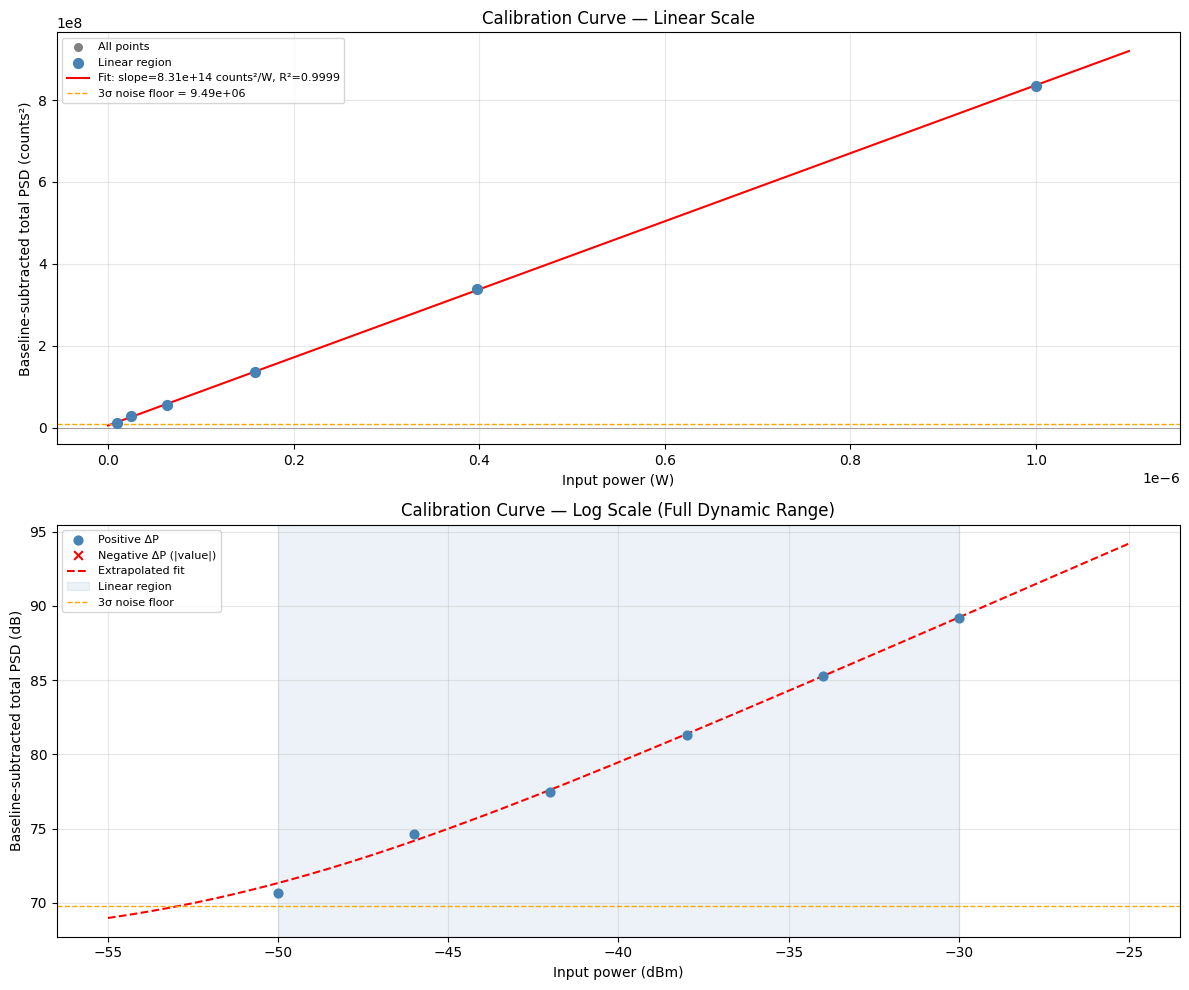

In [21]:
# Step 7 — Calibration curve visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# --- Top: linear scale (Watts vs counts²) ---
# All points
ax1.scatter(sub_df['P_watts'], sub_df['total_diff'], c='gray', s=30,
            label='All points', zorder=2)
# Linear region highlighted
ax1.scatter(sub_df.loc[linear_mask, 'P_watts'],
            sub_df.loc[linear_mask, 'total_diff'],
            c='steelblue', s=50, label='Linear region', zorder=3)

# Fit line over extended range
P_range = np.linspace(0, sub_df['P_watts'].max() * 1.1, 200)
ax1.plot(P_range, slope_cal * P_range + intercept_cal, 'r-', lw=1.5,
         label=f'Fit: slope={slope_cal:.2e} counts²/W, R²={r_cal**2:.4f}')

# Noise floor
ax1.axhline(3 * noise_floor_std, color='orange', ls='--', lw=1,
            label=f'3σ noise floor = {3*noise_floor_std:.2e}')
ax1.axhline(0, color='gray', lw=0.5)

ax1.set_xlabel('Input power (W)')
ax1.set_ylabel('Baseline-subtracted total PSD (counts²)')
ax1.set_title('Calibration Curve — Linear Scale')
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3)

# --- Bottom: log-log (dBm vs dB) showing full dynamic range ---
# Convert total_diff to dB (use abs for log, mark sign)
total_diff_all = sub_df['total_diff'].values
positive = total_diff_all > 0

# Plot positive values in dB
input_dbm_all = sub_df['siggen_amp_dBm'].values
ax2.scatter(input_dbm_all[positive],
            10 * np.log10(total_diff_all[positive]),
            c='steelblue', s=40, label='Positive ΔP', zorder=3)
ax2.scatter(input_dbm_all[~positive],
            10 * np.log10(np.abs(total_diff_all[~positive])),
            c='red', marker='x', s=40, label='Negative ΔP (|value|)', zorder=3)

# Extrapolated fit line across full dBm range
dbm_range = np.linspace(-55, -25, 200)
P_range_w = 10**(dbm_range / 10) * 1e-3
fit_counts2 = slope_cal * P_range_w + intercept_cal
fit_positive = fit_counts2 > 0
ax2.plot(dbm_range[fit_positive],
         10 * np.log10(fit_counts2[fit_positive]),
         'r--', lw=1.5, label='Extrapolated fit')

# Mark linear region bounds
dbm_min = sub_df.loc[linear_mask, 'siggen_amp_dBm'].min()
dbm_max = sub_df.loc[linear_mask, 'siggen_amp_dBm'].max()
ax2.axvspan(dbm_min, dbm_max, alpha=0.1, color='steelblue', label='Linear region')

# Noise floor in dB
ax2.axhline(10 * np.log10(3 * noise_floor_std), color='orange', ls='--', lw=1,
            label='3σ noise floor')

ax2.set_xlabel('Input power (dBm)')
ax2.set_ylabel('Baseline-subtracted total PSD (dB)')
ax2.set_title('Calibration Curve — Log Scale (Full Dynamic Range)')
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()